# Project 4, APS1070 Fall 2021
#### **Linear Regression -  13 points**
**Deadline: Nov 26, 21:00**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Your **name**: 
*   Your **student number**: 



## Part 1 - Getting Started [1.5 marks]

Ailerons are small hinged sections on the outboard portion of a wing used to control the roll of an airplane. In this project, we are going to design a controller to manage the ailerons of an aircraft based on supervised learning.

![Aileron](https://www.eecg.utoronto.ca/~hadizade/APS1070/p3Ar.jpg)




The following dataset contains 13750 instances, where each instance is a set of 40 features describing the airplane's status. Our goal is to use these features to predict the `Goal` column, which is a command that our controller should issue. We will make our predictions by implementing linear regression.

In [16]:
import pandas as pd
import numpy as np

df=pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

Here are the steps to complete this portion:

1. Print the dataframe.
2. Prepare your dataset as follows: **[0.5]**
  *   Using `train_test_split` from Sklearn, split the dataset into training, validation, and test sets ($70\%$ training, $15\%$ validation, and $15\%$ test). When splitting, set `random_state=1`.
  *   Standardize the data using `StandardScaler` from sklearn. 
  *   Insert the first column of all $1$s in the training, validation, and test set.
 
3. Explain the difference between epoch and iteration in the Gradient descent algorithm (SGD/mini-batch)? **[1]**

In [17]:
df

,inputs ClimbRate,Sgz,P,Q,CurPitch,CurRoll,AbsRoll,DiffClb,DiffRollRate,DiffDiffClb,SeTime1,SeTime2,SeTime3,SeTime4,SeTime5,SeTime6,SeTime7,SeTime8,SeTime9,SeTime10,SeTime11,SeTime12,SeTime13,SeTime14,DiffSeTime1,DiffSeTime2,DiffSeTime3,DiffSeTime4,DiffSeTime5,DiffSeTime6,DiffSeTime7,DiffSeTime8,DiffSeTime9,DiffSeTime10,DiffSeTime11,DiffSeTime12,DiffSeTime13,DiffSeTime14,Alpha,Se,Goal
0,-17,-6,-0.03,0.14,0.59,-0.5,-11,-9,0.015,-0.2,0.019,0.019,0.019,0.020,0.020,0.020,0.020,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.000,0.0,-0.002,0.0,0.0,0.0,-0.002,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.6,0.021,-0.0008
1,-791,15,-0.28,-0.34,1.11,0.9,-10,27,-0.002,4.7,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.4,0.013,-0.0009
2,-46,48,-0.42,0.07,0.57,0.6,-5,-8,-0.008,0.0,0.018,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,-0.002,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.019,-0.0005
3,496,-5,-0.21,-0.04,0.03,-0.5,-7,6,-0.002,-0.1,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.018,0.018,0.017,-0.001,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.001,0.0,0.001,0.0,0.5,0.017,-0.0005
4,-124,16,-0.02,0.05,0.61,-0.2,-9,-3,0.000,0.0,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.018,-0.0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13745,-53,-13,-0.07,0.02,0.58,-2.3,-15,12,0.022,-0.8,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,-0.001,0.0,0.5,0.019,-0.0007
13746,1,4,-0.11,-0.07,0.47,0.8,-5,8,-0.003,-0.2,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.016,-0.0004
13747,425,-14,0.40,0.07,0.41,-2.1,-16,12,0.031,-0.7,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.034,0.034,0.034,0.034,0.032,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.001,0.0,0.000,0.0,0.001,0.0,0.9,0.032,-0.0015
13748,102,-10,-0.19,0.08,1.30,0.5,-10,-3,-0.003,-0.2,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,1.4,0.051,-0.0015


In [86]:
import numpy as np
from sklearn.model_selection import train_test_split
X = np.array(df.drop('Goal',axis = 1).copy())
y_true = np.array(df['Goal'].copy())
X_train, X_rem, y_train, y_rem = train_test_split(X, y_true, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, random_state = 1, test_size = 0.5)

In [90]:
from sklearn import preprocessing
#Train set standardization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
#Validation set stardardization
X_val_scaled = scaler.transform(X_val)
#Test set standardization
X_test_scaled = scaler.transform(X_test)

In [91]:
#Adding the ones column
X_train_scaled = np.hstack((np.ones(X_train.shape[0]).reshape(-1,1), X_train_scaled.copy()))
X_val_scaled = np.hstack((np.ones(X_val.shape[0]).reshape(-1,1), X_val_scaled.copy()))
X_test_scaled = np.hstack((np.ones(X_test.shape[0]).reshape(-1,1), X_test_scaled.copy()))

## Part 2 - Linear Regression Using Direct Solution [1 marks]

Implement the direct solution of the linear regression problem on the training set. **[0.5]**

**Note: You should use scipy.linalg.inv to perform the matrix inversion, as numpy.linalg.inv may cause numerical issues.**

Report the root-mean-square error (RMSE) for both the training and validation sets. **[0.5]**

You may use `mean_squared_error` from Sklearn for computing the RMSE.

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.linalg import inv
import scipy


In [26]:
def rmse(yPred, y):
    return np.sqrt(mean_squared_error(yPred, y))

In [99]:
W = np.dot(scipy.linalg.inv(np.dot(X_train_scaled.T, X_train_scaled)), np.dot(X_train_scaled.T, y_train))
ytrain_pred = np.dot(X_train_scaled, W)
print('Train sets RMSE:',rmse(ytrain_pred,y_train))
yval_pred = np.dot(X_val_scaled, W)
print('Validation sets RMSE:',rmse(yval_pred,y_val))
RMSE_ds = rmse(yval_pred,y_val)

Train sets RMSE: 0.00017630525201590516
Validation sets RMSE: 0.00017357966052740928


## Part 3 - Full Batch Gradient Descent [2 marks]

We will now implement a "full batch" gradient descent algorithm and record the training time for our model. Recall that the full batch gradient descent is,
 $$w_t = w_{t-1} - \alpha~g_t$$ where $\alpha$ is the learning rate and $g_t$ is your gradient, computed on the entire data. 

Here are the steps for this part:

* Implement gradient descent for linear regression using a fixed learning rate of $\alpha= 0.01$, and iterate until your model's **validation** RMSE converges. 

  We consider the gradient descent as having converged when RMSE on the validation set using gradient descent satisfies:

  $$ RMSE_\text{GD} \leq 1.001 \times RMSE_\text{Direct Solution}$$

  where $RMSE_\text{Direct Solution}$ is the RMSE on the validation set using the direct solution that you have calculated in the previous part. 

  We refer to the quantity $RMSE_\text{Direct Solution}\times 1.001$ as the convergence threshold (CT).

*  Record the training time (from the first iteration until convergence) using the `time.time()` function. Be sure to compute the gradients yourself! Take a look at the code provided in the tutorial. **[0.5]**

* Plot the training RMSE and the validation RMSE vs. epoch on the same figure.  **[0.5]**

* Comment on overfitting/underfitting by observing the training and validation RMSE **[1]**

**Hint**: Initialize your weights with small random numbers (<$0.001$)

In [35]:
import time
start_time = time.time() ## Records current time
#X = X_val_scaled
w = (np.random.random(41)).reshape(1,-1) ### Inital weights
w=w/10000 #To shorten the running time
lr = 0.01  ### Learning rate
rmse_val_array=[]
rmse_train_array=[]

RMSE = 1
CT = RMSE_ds*1.001
while CT <= RMSE:
  #Prediction
    y_val_pred= np.dot(X_val_scaled,w.T).reshape (-1,1)
    y_train_pred = np.dot(X_train_scaled,w.T).reshape(-1,1)
    #RMSE
    RMSE = rmse(y_val_pred,y_val)
    RMSE_train = rmse(y_train_pred,y_train)
    rmse_val_array.append(RMSE)
    rmse_train_array.append(RMSE_train)
    gradient = (1/len(y_train_pred) * np.dot(X_train_scaled.T, y_train_pred-y_train.reshape(-1,1))).reshape(1,-1)
    w = w - lr * gradient ### weight update

    
## GD Script -- Sample code in tutorial! ##

print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))

--- Total Training Time: 0.6224253177642822 (s) ---


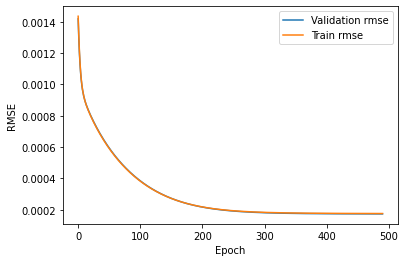

In [36]:
plt.plot(rmse_val_array, label = 'Validation rmse')
plt.plot(rmse_train_array,label = 'Train rmse')
plt.plot()
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(loc = 'best')
plt.show()


# Comments
Since the training RMSE and validation RMSE and really close and Validation RMSE is a little bit higher than training RMSE.This result is what we want, so this model is a good fit.

## Part 4 - Mini-batch and Stochastic Gradient Descent [4 marks]

Write a function that performs mini-batch gradient descent until the convergence threshold (CT) is reached. **[1]**

The inputs of that function are: 
  * Input data (training/validation), Batch size, Learning Rate, Convergence Threshold (CT)

Your function will return the following arrays: 
 * The final weights after training.
 * The training RMSE at each epoch.
 * The validation RMSE at each epoch.
 * An array that has the elapsed time from the start of the training process to the end of each epoch (e.g., if each epoch takes exactly 2 seconds, the array would look like: [2 4 6 8 ...]).

Notes: 
* For certain batch sizes, GD might not converge to a solution. For that reason, you need to check the RMSE of the validation/training set at each epoch, and if it's getting larger and larger, you should stop the training for that case (the design is up to you!).
* CT will help you to know when your model is converged. 
* **Important: after each epoch, you need to shuffle the entire training set.** This ensures that new mini-batches are selected for every epoch. Hint: use `np.random.permutation`. 

Let's now use the function to investigate the effect of batch size on convergence. When the batch size is 1, we call that stochastic gradient descent. When the batch size equals the # of training data, it is full-batch (i.e., all data points are used at every iteration). Anywhere in between is mini-batch (we use some of the data).
  * Sweep different values for the mini-batch size (at least 5 values), each time using a learning rate of $\alpha= 0.01$. **Hint: Try batch sizes that are powers of two (e.g., 2,4,8,16,32,64,128...).** These batch sizes fit better on the hardware and may achieve higher performance.  **[0.5]**

Provide the following $3$ plots:
  1.  Plot training and validation RMSE vs. **epoch** for all the **converging** batch sizes (some batch sizes might not converge) in a figure. The X-axis is Epoch # and the Y-axis is RMSE. **[0.5]**
  2. Plot training and validation RMSE vs. **time** for all the **converging** batch sizes in a figure. The X-axis is Time, and the Y-axis is RMSE. **[0.5]**
  3. Plot Total training time (y-axis) vs. Batch size (x-axis). **[0.5]**

Describe your findings, including the main takeaways from each of your plots. **[1]**

# Findings
# **The model will converge when batch size is greater or equal to 64, for sizes that are less than 64, it will diverge and tends to go to infinity. Sizes between 64 and 1024 will converge faster and sizes between 2048 to 8192 tends to take longer to converge.**

In [61]:
#Define a function
def MiniGD(Xtrain, ytrain, Xval, yval, BS, lr, CT):
  import time
  very_start_time = time.time()
  w = (np.random.random(41)/10000).reshape(1,-1) ### Inital weights
  rmse_val_array=[]
  rmse_train_array=[]
  time_array = []
  RMSE = 1
  t=0
  k=0
  while CT <= RMSE:
    m = Xtrain.shape[0]# m is number of samples of Xtrain
    #Shuffle the data
    indexes = np.random.permutation(m)
    Xtrain = Xtrain[indexes,:]
    ytrain = ytrain[indexes]
    if k > 20000: #Set a threshold for divergence
      return w,time_array,rmse_val_array,rmse_train_array,total_time,1
      break
    
    start_time = time.time()
    for i in range(int(m/BS)):
      k=k+1
      Xtrain2 = Xtrain[int(BS*i):int(BS*(i+1)),:].copy()
      ytrain2 = ytrain[int(BS*i):int(BS*(i+1))].copy()

      y_train_pred_2 = np.dot(Xtrain2,w.T).reshape(-1,1)
      gradient = (1/len(y_train_pred_2) * np.dot(Xtrain2.T, y_train_pred_2-ytrain2.reshape(-1,1))).reshape(1,-1)
      w = w - lr * gradient ### weight update
    y_val_pred= np.dot(Xval,w.T).reshape (-1,1)
    y_train_pred = np.dot(Xtrain,w.T).reshape(-1,1) 
    RMSE = rmse(y_val_pred,yval)
    RMSE_train = rmse(y_train_pred,ytrain)
    a = time.time()-start_time
    total_time = time.time()-very_start_time
    t=t+a
    time_array.append(t)
    rmse_val_array.append(RMSE)
    rmse_train_array.append(RMSE_train)
  return w,time_array,rmse_val_array,rmse_train_array,total_time,0

Text(0.5, 1.0, 'Time vs Batch size')

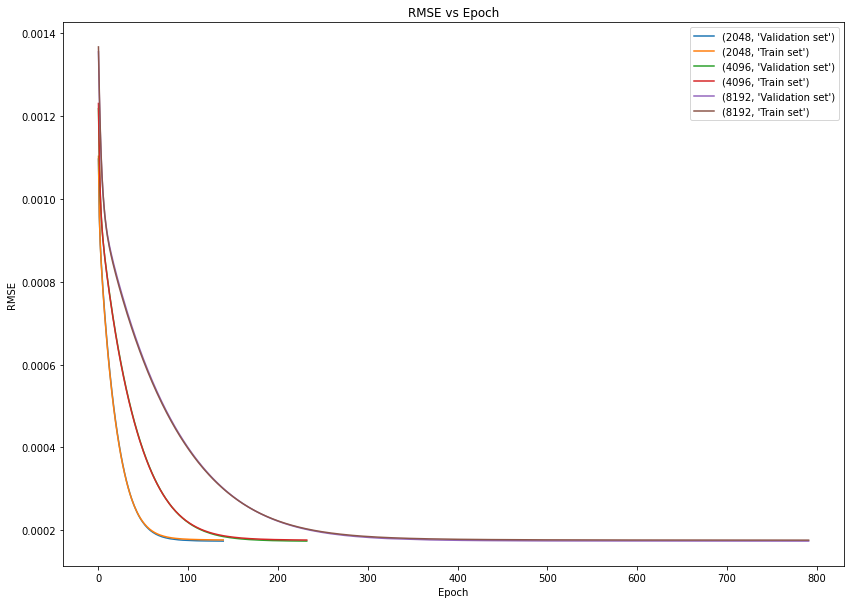

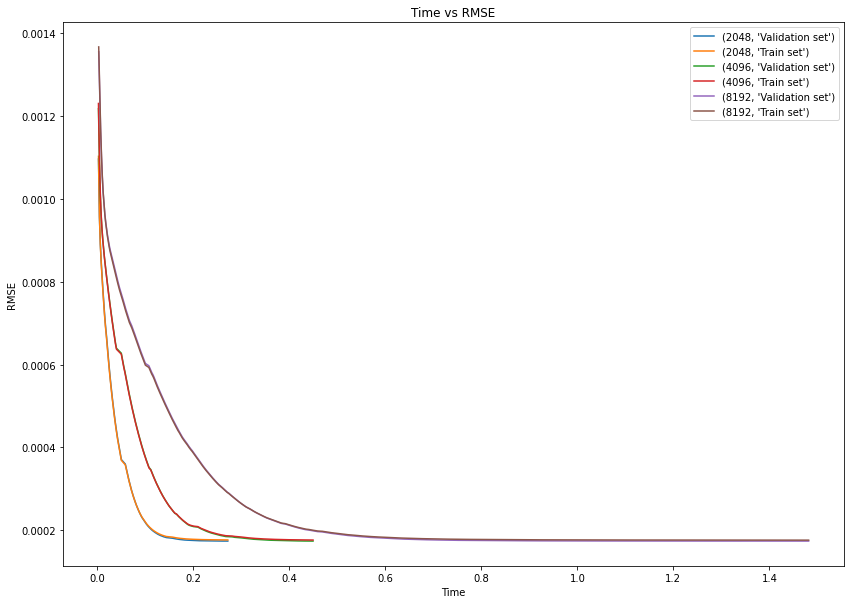

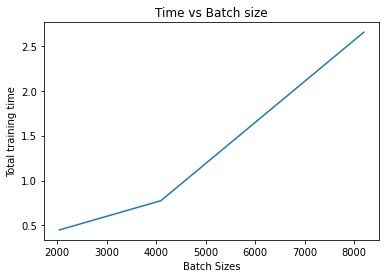

In [64]:
# Trying large batch size
k = [2048,4096,8192]
t = []
plt.figure(1,figsize=(14,10))
plt.figure(2,figsize=(14,10))
for i in k:
  w,time_array,rmse_array,rmse_train_array,total_time,dt = MiniGD(X_train_scaled,y_train,X_val_scaled,y_val,BS=i,lr=0.01,CT=RMSE_direct*1.001)
  if dt == 1: 
    print('Batch size ',i,'cannot converge')
  t.append(total_time)
  plt.figure(1)
  plt.plot(rmse_array, label = (i,'Validation set'))
  plt.plot(rmse_train_array,label = (i,'Train set'))
  plt.xlabel("Epoch")
  plt.ylabel("RMSE")
  plt.legend(loc = 'upper right')
  plt.title('RMSE vs Epoch')
  plt.figure(2)
  plt.plot(time_array,rmse_array,label = (i,'Validation set'))
  plt.plot(time_array,rmse_train_array,label = (i,'Train set'))
  plt.xlabel("Time")
  plt.ylabel("RMSE")
  plt.legend(loc = 'upper right')
  plt.title('Time vs RMSE')
plt.figure(3)
plt.plot(k,t)
plt.xlabel("Batch Sizes")
plt.ylabel("Total training time")
plt.title('Time vs Batch size')


Batch size  8 cannot converge
Batch size  16 cannot converge
Batch size  32 cannot converge


Text(0.5, 1.0, 'Time vs Batch size')

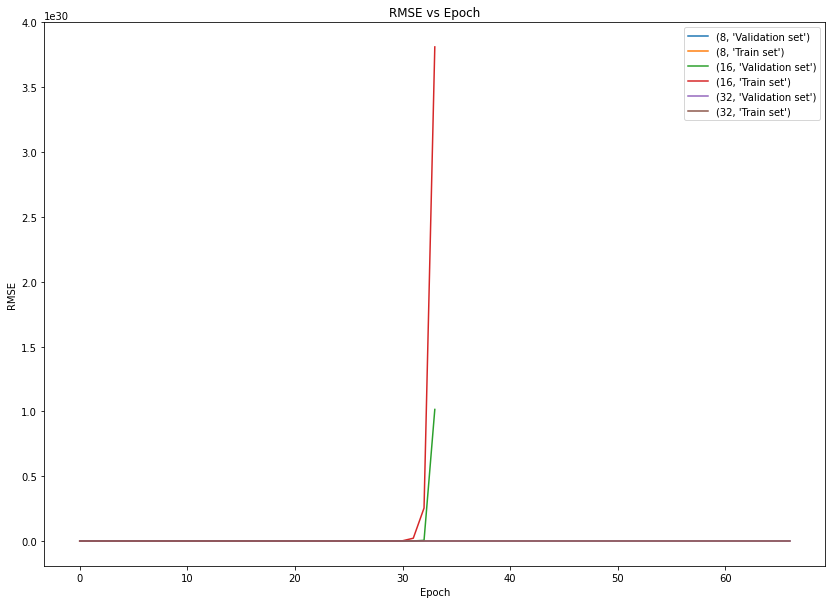

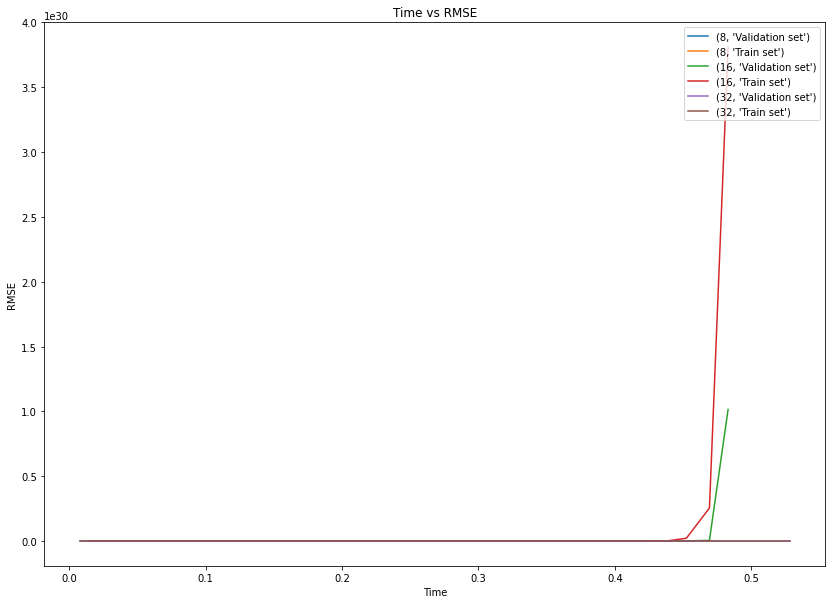

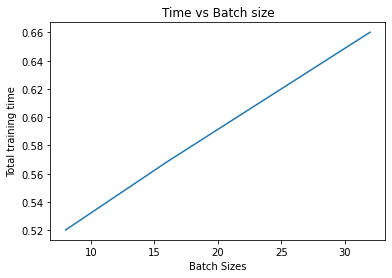

In [62]:
#Trying small batch size
k = [8,16,32]
t = []
plt.figure(1,figsize=(14,10))
plt.figure(2,figsize=(14,10))
for i in k:
  w,time_array,rmse_array,rmse_train_array,total_time,dt = MiniGD(X_train_scaled,y_train,X_val_scaled,y_val,BS=i,lr=0.01,CT=RMSE_direct*1.001)
  if dt == 1: 
    print('Batch size ',i,'cannot converge')
  t.append(total_time)
  plt.figure(1)
  plt.plot(rmse_array, label = (i,'Validation set'))
  plt.plot(rmse_train_array,label = (i,'Train set'))
  plt.xlabel("Epoch")
  plt.ylabel("RMSE")
  plt.legend(loc = 'upper right')
  plt.title('RMSE vs Epoch')
  plt.figure(2)
  plt.plot(time_array,rmse_array,label = (i,'Validation set'))
  plt.plot(time_array,rmse_train_array,label = (i,'Train set'))
  plt.xlabel("Time")
  plt.ylabel("RMSE")
  plt.legend(loc = 'upper right')
  plt.title('Time vs RMSE')
plt.figure(3)
plt.plot(k,t)
plt.xlabel("Batch Sizes")
plt.ylabel("Total training time")
plt.title('Time vs Batch size')


Text(0.5, 1.0, 'Time vs Batch size')

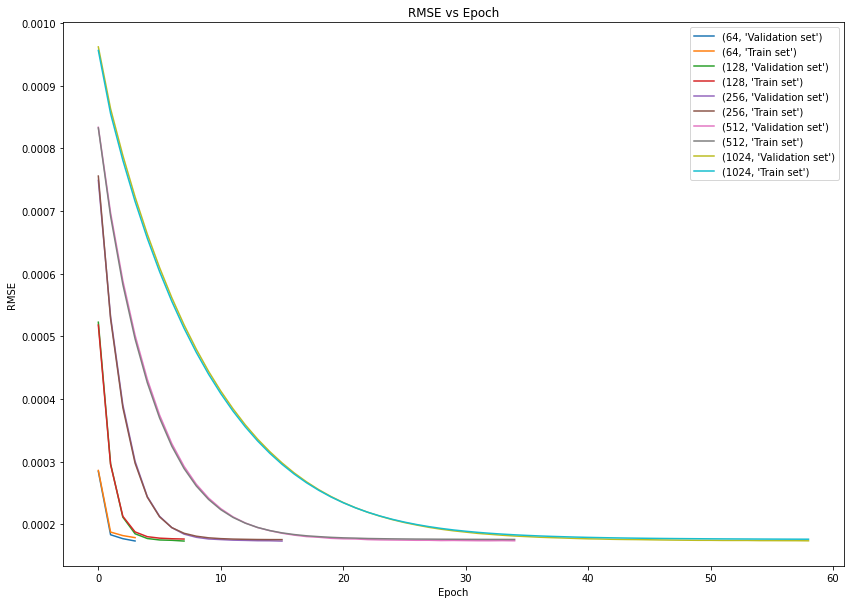

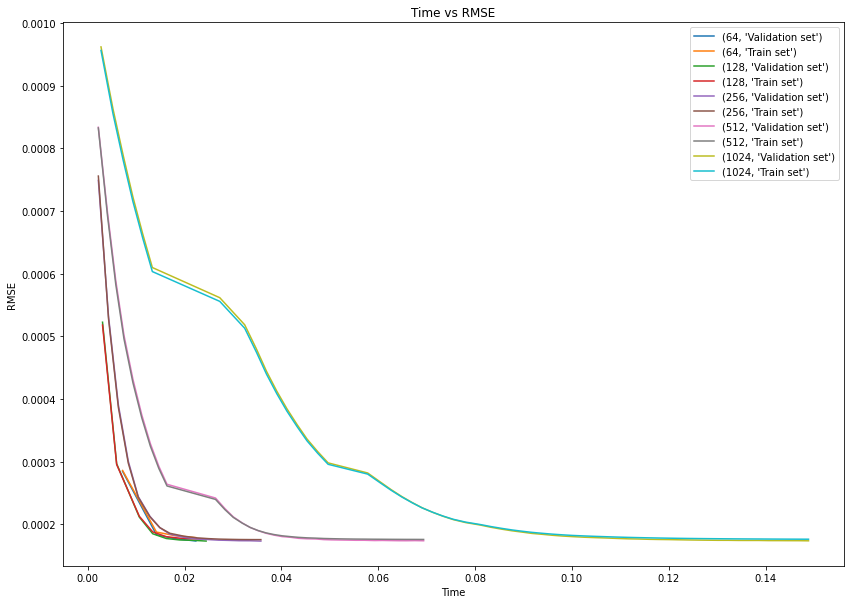

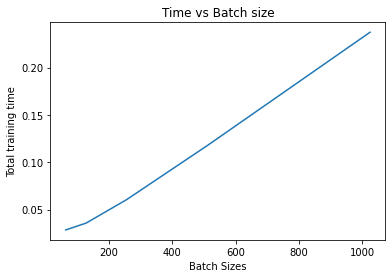

In [63]:
#We found that batch size bigger or equal 64 will make the model converge
k = [64,128,256,512,1024]
t = []
plt.figure(1,figsize=(14,10))
plt.figure(2,figsize=(14,10))
for i in k:
  w,time_array,rmse_array,rmse_train_array,total_time,dt = MiniGD(X_train_scaled,y_train,X_val_scaled,y_val,BS=i,lr=0.01,CT=RMSE_direct*1.001)
  if dt == 1: 
    print('Batch size ',i,'cannot converge')
  t.append(total_time)
  plt.figure(1)
  plt.plot(rmse_array, label = (i,'Validation set'))
  plt.plot(rmse_train_array,label = (i,'Train set'))
  plt.xlabel("Epoch")
  plt.ylabel("RMSE")
  plt.legend(loc = 'upper right')
  plt.title('RMSE vs Epoch')
  plt.figure(2)
  plt.plot(time_array,rmse_array,label = (i,'Validation set'))
  plt.plot(time_array,rmse_train_array,label = (i,'Train set'))
  plt.xlabel("Time")
  plt.ylabel("RMSE")
  plt.legend(loc = 'upper right')
  plt.title('Time vs RMSE')
plt.figure(3)
plt.plot(k,t)
plt.xlabel("Batch Sizes")
plt.ylabel("Total training time")
plt.title('Time vs Batch size')


## Part 5 - Introducing Momentum [3.5 marks]

Momentum is a popular technique that helps the gradient descent algorithm to converge faster. Simply, it behaves like a moving average of gradients. First, take a look at [here](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) to get familiar with the concept.

To summarize, If the weight update formula in the time-step $t$ is $w_t = w_{t-1} - \alpha~g_t$, the $g_t$ using momentum could be computed as $g_t = \beta~g_{t-1} + (1-\beta) \frac{{\partial J}}{\partial w}$. Where $\beta$ is the momentum coefficient, between [0, 1]. 

Weight updates ($g_t$) with momentum are not only computed based on the derivative of the loss function but also is a function of previous weight updates.

If you put $\beta=0$ in the $g_t$ equation, it would be the original gradient descent method. 

* Add momentum to your training function. **[1]**
* Train a linear model with a specific batch size and various values of momentums. 
  *  Plot your training and validation RMSE for each epoch. **[1]**
  *  With some plots (or tables) show how momentum affects the training time.  **[1]**
  * Summarize your experiments and comment on the effect of momentum. **[0.5]**

# Summary
# With RMSE vs Epoch and RMSE vs time plots choosing same batch size but different beta, I found that there is no linear relationship between beta and training time because beta 0.8 and 0.2 have very similar training time although their far from each other for the value of beta. And I found that the validation and train set have similar curve for batch size of 128.

In [71]:
def MiniGD_mom(Xtrain, ytrain, Xval, yval, BS, lr, CT,beta):
  import time
  very_start_time = time.time()
  w = (np.random.random(41)/10000).reshape(1,-1) ### Inital weights
  rmse_val_array=[]
  rmse_train_array=[]
  time_array = []
  RMSE = 1
  t=0
  k=0
  gt = 0
  while CT <= RMSE:
    m = Xtrain.shape[0]# m is number of samples of Xtrain
    #Shuffle the data
    indexes = np.random.permutation(m)
    Xtrain = Xtrain[indexes,:]
    ytrain = ytrain[indexes]
    if k > 20000: #Set a threshold for divergence
      return w,time_array,rmse_val_array,rmse_train_array,total_time,1
      break
    
    start_time = time.time()
    for i in range(int(m/BS)):
      k=k+1
      Xtrain2 = Xtrain[int(BS*i):int(BS*(i+1)),:].copy()
      ytrain2 = ytrain[int(BS*i):int(BS*(i+1))].copy()

      y_train_pred_2 = np.dot(Xtrain2,w.T).reshape(-1,1)
      gradient = (1/len(y_train_pred_2) * np.dot(Xtrain2.T, y_train_pred_2-ytrain2.reshape(-1,1))).reshape(1,-1)
      gt = beta*gt + (1-beta)*gradient
      w = w - lr * gt ### weight update

    y_val_pred= np.dot(Xval,w.T).reshape (-1,1)
    y_train_pred = np.dot(Xtrain,w.T).reshape(-1,1) 
    RMSE = rmse(y_val_pred,yval)
    RMSE_train = rmse(y_train_pred,ytrain)
    a = time.time()-start_time
    total_time = time.time()-very_start_time
    t=t+a
    time_array.append(t)
    rmse_val_array.append(RMSE)
    rmse_train_array.append(RMSE_train)
  return w,time_array,rmse_val_array,rmse_train_array,total_time,0

Text(0.5, 1.0, 'Time vs RMSE')

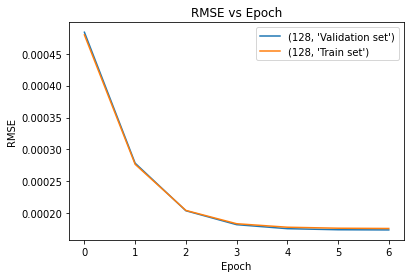

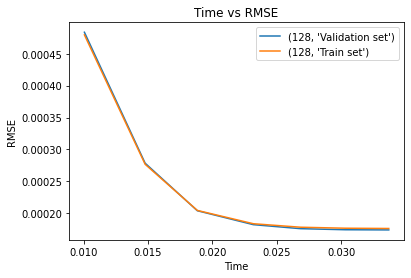

In [84]:
w,time_array,rmse_array,rmse_train_array,total_time,dt = MiniGD_mom(X_train_scaled,y_train,X_val_scaled,y_val,BS=128,lr=0.01,CT=RMSE_direct*1.001,beta=0.2)

if dt == 1: 
  print('Batch size ',128,'cannot converge')
t.append(total_time)
plt.figure(1)
plt.plot(rmse_array, label = (128,'Validation set'))
plt.plot(rmse_train_array,label = (128,'Train set'))
plt.xlabel("Epoch",)
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')
plt.title('RMSE vs Epoch')
plt.figure(2)
plt.plot(time_array,rmse_array,label = (128,'Validation set'))
plt.plot(time_array,rmse_train_array,label = (128,'Train set'))
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')
plt.title('Time vs RMSE')

Text(0.5, 1.0, 'Time vs RMSE')

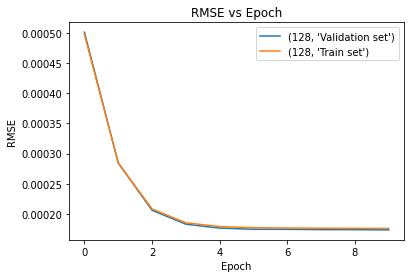

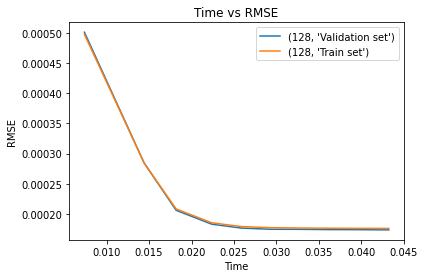

In [75]:
w,time_array,rmse_array,rmse_train_array,total_time,dt = MiniGD_mom(X_train_scaled,y_train,X_val_scaled,y_val,BS=128,lr=0.01,CT=RMSE_direct*1.001,beta=0.5)

if dt == 1: 
  print('Batch size ',128,'cannot converge')
t.append(total_time)
plt.figure(1)
plt.plot(rmse_array, label = (128,'Validation set'))
plt.plot(rmse_train_array,label = (128,'Train set'))
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')
plt.title('RMSE vs Epoch')
plt.figure(2)
plt.plot(time_array,rmse_array,label = (128,'Validation set'))
plt.plot(time_array,rmse_train_array,label = (128,'Train set'))
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')
plt.title('Time vs RMSE')

Text(0.5, 1.0, 'Time vs RMSE')

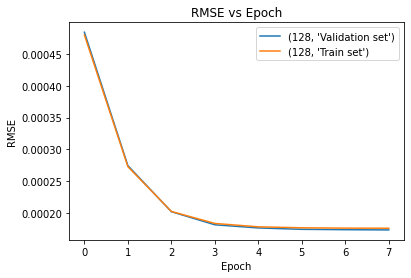

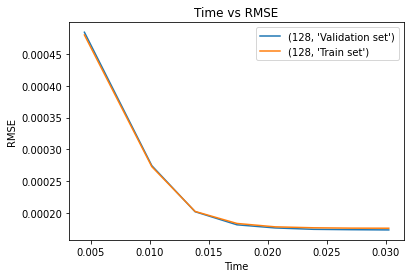

In [78]:
w,time_array,rmse_array,rmse_train_array,total_time,dt = MiniGD_mom(X_train_scaled,y_train,X_val_scaled,y_val,BS=128,lr=0.01,CT=RMSE_direct*1.001,beta=0.8)

if dt == 1: 
  print('Batch size ',128,'cannot converge')
t.append(total_time)
plt.figure(1)
plt.plot(rmse_array, label = (128,'Validation set'))
plt.plot(rmse_train_array,label = (128,'Train set'))
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')
plt.title('RMSE vs Epoch')
plt.figure(2)
plt.plot(time_array,rmse_array,label = (128,'Validation set'))
plt.plot(time_array,rmse_train_array,label = (128,'Train set'))
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')
plt.title('Time vs RMSE')

Text(0.5, 1.0, 'Time vs RMSE')

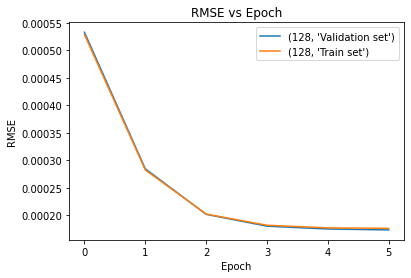

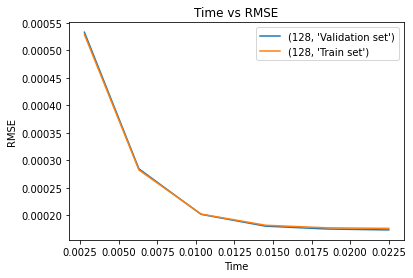

In [77]:
w,time_array,rmse_array,rmse_train_array,total_time,dt = MiniGD_mom(X_train_scaled,y_train,X_val_scaled,y_val,BS=128,lr=0.01,CT=RMSE_direct*1.001,beta=0.9)

if dt == 1: 
  print('Batch size ',128,'cannot converge')
t.append(total_time)
plt.figure(1)
plt.plot(rmse_array, label = (128,'Validation set'))
plt.plot(rmse_train_array,label = (128,'Train set'))
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')
plt.title('RMSE vs Epoch')
plt.figure(2)
plt.plot(time_array,rmse_array,label = (128,'Validation set'))
plt.plot(time_array,rmse_train_array,label = (128,'Train set'))
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')
plt.title('Time vs RMSE')

## Part 6 - Finalizing a model [1 marks]
Based on your findings from the previous parts, pick a model (or combination of model settings) that you think would work best for our dataset and evaluate it on the test set. 

Briefly describe your model selections/settings. **[0.5]** 

Summarize the performance of your model for the task of managing ailerons of an aircraft. **[0.5]** 

# Answer:
# I will use mini-batch model with a batch size of 64 since it has the least training time from my results.
# The model took about 350 epochs to converge and the running time is less than 1 second. The result is moderate.

In [93]:
w,time_array,rmse_array,rmse_train_array,total_time,dt = MiniGD(X_train_scaled,y_train,X_test_scaled,y_test,BS=i=64,lr=0.01,CT=RMSE_direct*1.001)

Text(0.5, 1.0, 'Time vs RMSE')

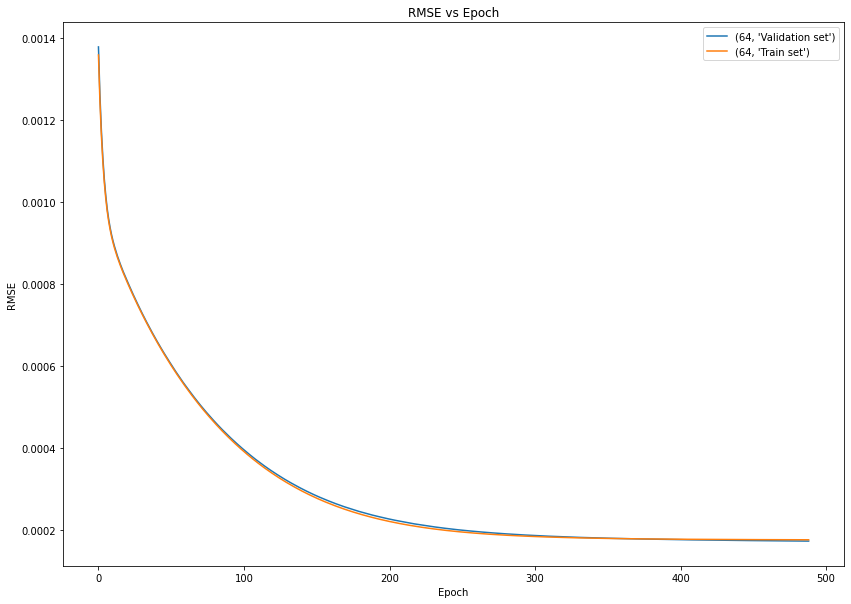

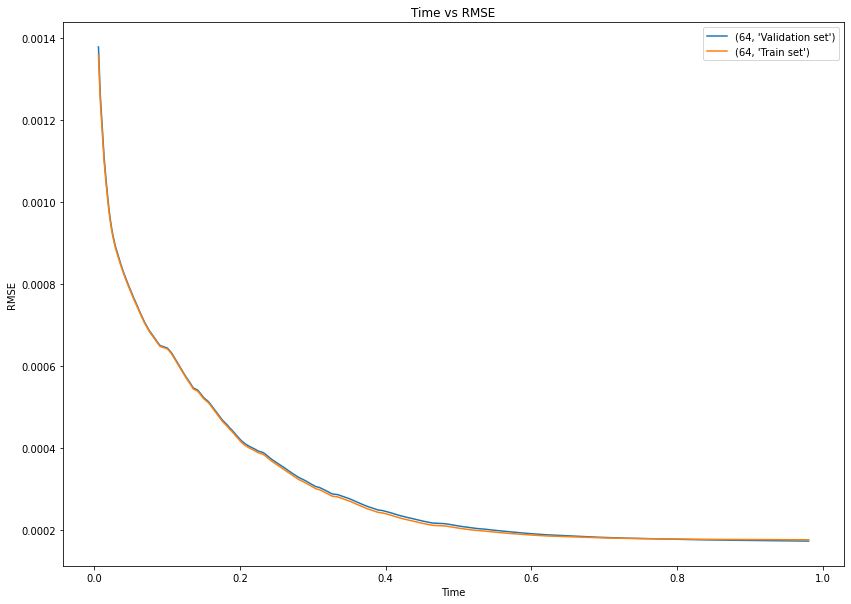

In [96]:
#Performance
t = []
plt.figure(1,figsize=(14,10))
plt.figure(2,figsize=(14,10))

t.append(total_time)
plt.figure(1)
plt.plot(rmse_array, label = (64,'Validation set'))
plt.plot(rmse_train_array,label = (64,'Train set'))
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')
plt.title('RMSE vs Epoch')
plt.figure(2)
plt.plot(time_array,rmse_array,label = (64,'Validation set'))
plt.plot(time_array,rmse_train_array,label = (64,'Train set'))
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.legend(loc = 'upper right')
plt.title('Time vs RMSE')